In [37]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

%matplotlib inline

In [38]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

dates = data.index[1:]

In [39]:
window = 5
D = []
for t in range(len(delta_r) - window):
    y = ret[t : t+window]
    x = delta_r[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    D.append(- result.params[0])

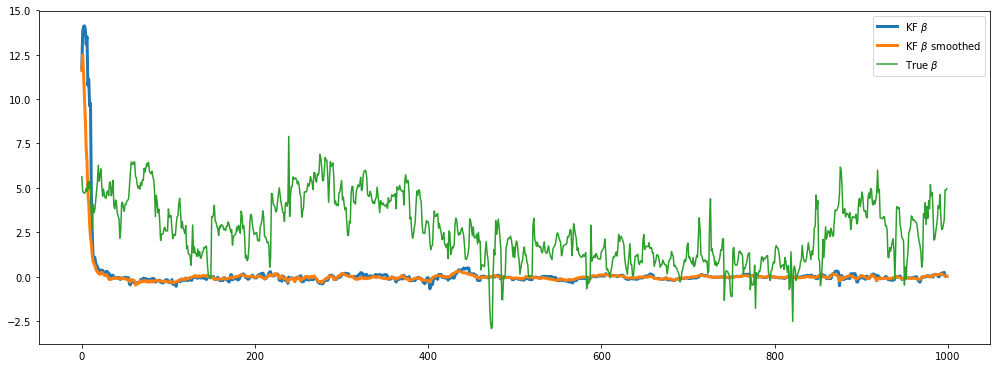

In [40]:
# Run Kalman filter on returns data
Total_T = 1000

delta_r = 1e-2
trans_cov_r = delta_r / (1 - delta_r) * np.eye(2) # How much random walk wiggles
obs_mat_r = np.expand_dims(np.vstack([[D[:Total_T]], [np.ones(Total_T)]]).T, axis=1)


kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y_r is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[-5,0],
                  initial_state_covariance=np.array([[1, 0], [0, 0.1]]),
                    
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat_r,
                  
                  observation_covariance=.01,
                  transition_covariance=trans_cov_r)

theta = kf_r.em(prices[:Total_T])
state_means_r, _ = kf_r.filter(prices[:Total_T])
state_means_r_smooth, _ = kf_r.smooth(prices[:Total_T])

fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(2, 1, 1)
#_, axarr = plt.subplots(2, sharex=True)
ax.plot(state_means_r[:,0], label=r'KF $\beta$', lw=3)
ax.plot(state_means_r_smooth[:,0], label=r'KF $\beta$ smoothed', lw=3)
ax.plot(D[:Total_T], label=r'True $\beta$')
ax.legend()

fig.tight_layout()
